# Advanced Lab: Session 5 -> Supervised Learning
## Feature Selection and Best Model Parameter Selection
## n-Cross-Fold Validation

Here we will use n-cross-fold validation to select the best features for a variety of models and their best performing model paramaters

In [4]:
# Standard libraries we've been using to process and visualise our data
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
 # setting the fonts for graphs

# Machine learning based functions imported from the sklearn library

from sklearn.feature_selection import RFE, RFECV

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import r2_score, classification_report, ConfusionMatrixDisplay


--- IGNORE --- Preparing my own data ---

In [5]:
# Loading in my datasets
my_dye_descriptors = pd.read_csv("Datasets/SolarCells2/dye_ecfp6.csv", index_col=0)
my_dye_desired_property = pd.read_csv("Datasets/SolarCells2/fp_activity.csv", index_col=0)['PCE'].to_frame()

# Creating a desired property suitable for a classification task as before
activity = pd.cut(my_dye_desired_property['PCE'], bins=[0,5,10,14], labels=['Bad', 'Okay', 'Good'])
my_dye_desired_property['PCE-Activity'] = activity
my_dye_desired_property

,PCE,PCE-Activity
0,5.19,Okay
1,2.60,Bad
2,3.10,Bad
3,2.20,Bad
4,5.00,Bad
...,...,...
4419,7.39,Okay
4422,4.52,Bad
4423,6.09,Okay
4424,5.65,Okay


### Splitting data into training and test

In [6]:
my_dye_descriptors

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4423,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [7]:
# labelling the descriptors used to predict the desired property X
X = my_dye_descriptors

# For regression model
Y_reg = my_dye_desired_property['PCE']
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(X, Y_reg, test_size=0.33)

# For classification model
Y_clf = my_dye_desired_property['PCE-Activity']
X_train_clf, X_test_clf, Y_train_clf, Y_test_clf = train_test_split(X, Y_clf, test_size=0.2, stratify=Y_clf)

### Recursive Feature Elimination
#### Regression

n-Cross-Fold Validation

In [8]:
# Ridge Regression using default settings
# Initializing model used for feature selection
ridge = Ridge()

# selecting the number of features we'll consider at minimum (set yours to 1)
min_features = 1

# Object which allows RFE evaluated with Cross-fold validation
rfe_ridge_CV = RFECV(
    estimator=ridge,
    step=10,
    cv=2,
    scoring='r2',
    min_features_to_select=min_features,
    n_jobs=-1 # allows my computer to conduct this faster
)

rfe_ridge_CV.fit(X_train_reg, Y_train_reg)


# RandomForest Regression
rf = RandomForestRegressor()

rfe_rf_CV = RFECV(
    estimator=rf,
    step=10,
    cv=2,
    scoring='r2',
    min_features_to_select=min_features,
    n_jobs=-1
)

rfe_rf_CV.fit(X_train_reg, Y_train_reg)


RFECV(cv=2, estimator=RandomForestRegressor(), n_jobs=-1, scoring='r2', step=10)

Visualising Results

In [9]:
len(rfe_ridge_CV.cv_results_['mean_test_score']), 

(104,)

In [10]:
print(f"Optimal number of features for Ridge: {rfe_ridge_CV.n_features_}")
print(f"Optimal number of features for RandomForest {rfe_rf_CV.n_features_}")

# Collecting results in a dataframe
# Ridge Regression
n_scores = len(rfe_ridge_CV.cv_results_["mean_test_score"])

# FOR YOUR CODE 
n_features_ridge = range(min_features, n_scores+min_features)
n_features_ridge = range(min_features, 1024+10, 10)
# n_features_ridge = np.flip(np.arange(1024, min_features, -1))
print(n_features_ridge)
mean_ridge_CV_score = rfe_ridge_CV.cv_results_["mean_test_score"]

ridge_feature_selection_results = pd.DataFrame.from_dict({"Number of Features": n_features_ridge, "Mean R2 Score": mean_ridge_CV_score})

# Random Forest Regression
# FOR YOUR CODE
n_features_rf = range(min_features, 1024+10, 10)
# n_features_rf = np.flip(np.arange(1024, min_features-10, -10)
mean_rf_CV_score = rfe_rf_CV.cv_results_["mean_test_score"]

rf_feature_selection_results = pd.DataFrame.from_dict({"Number of Features": n_features_rf, "Mean R2 Score": mean_rf_CV_score})
rf_feature_selection_results


Optimal number of features for Ridge: 114
Optimal number of features for RandomForest 294
range(1, 1034, 10)


,Number of Features,Mean R2 Score
0,1,0.138387
1,11,0.226981
2,21,0.390499
3,31,0.449462
4,41,0.481085
...,...,...
99,991,0.548992
100,1001,0.554719
101,1011,0.548038
102,1021,0.550310


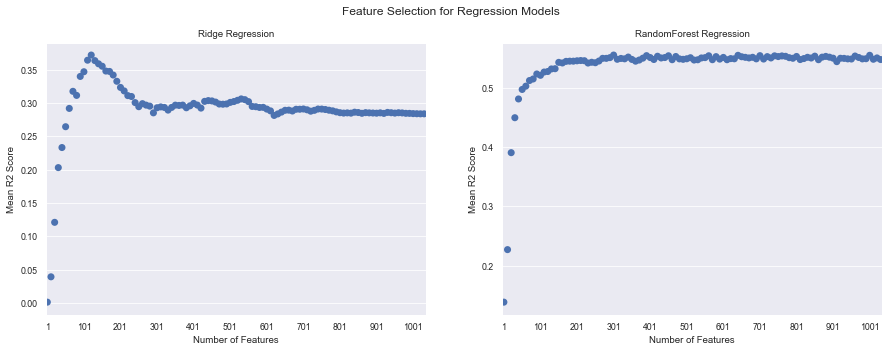

In [11]:
# Visualising mean scores over all fold for each feature elimination step
sns.set_theme('paper')
fig, axes = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Feature Selection for Regression Models')
sns.pointplot(ax=axes[0], data=ridge_feature_selection_results, x='Number of Features', y='Mean R2 Score', join=False)
axes[0].set_title(f"Ridge Regression")
tick_spacing = 10
axes[0].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(tick_spacing))

sns.pointplot(ax=axes[1], data=rf_feature_selection_results, x='Number of Features', y='Mean R2 Score', join=False)
axes[1].set_title(f"RandomForest Regression")
axes[1].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(tick_spacing))



#### Reducing Dataset to Selected Features
In my case for the Ridge Regression model, where performance (based on r2 score) has a clear maxima, I will choose the number of features selected by that of the RFECV method.
For the RandomForestRegression model, performance plateaus due to the nature of the algorithm. I will choose the "elbow" of the graph, selecting 300 features for a final RFE

In [12]:
# Ridge selected features, with RFECV results
X_train_reg_ridge_reduced = X_train_reg[X_train_reg.columns[rfe_ridge_CV.support_]]
# What's important to remember is that although we are using RFECV to remove features from the test set, the method found was trained on the training set
X_test_reg_ridge_reduced = X_test_reg[X_test_reg.columns[rfe_ridge_CV.support_]]

# RandomForest selected features, final RFE, using number of features I select (doesn't use CV)
rfe_rf = RandomForestRegressor()
rfe_selector = RFE(estimator=rfe_rf, n_features_to_select=120, step=10)
rfe_selector.fit(X_train_reg, Y_train_reg)

X_train_reg_rf_reduced = X_train_reg[X_train_reg.columns[rfe_selector.support_]]
X_test_reg_rf_reduced = X_test_reg[X_test_reg.columns[rfe_selector.support_]]

# RFE- Elimination Using the Principle of Occam's Razor



<p>Build and test a model using a reduced set of features:</p>
<ul>
    <li>What was the optimum number of features RFECV selected?</li> 
    <li>Did feature selection alone improve the results of your model?</li>
</ul>

#### Classification

n-Cross-Fold Validation

In [13]:
# LogisticRegression using default settings
# Initializing model used for feature selection
logreg = LogisticRegression()

min_features = 1

cv_stratified = StratifiedKFold(n_splits=2)

# Object which performs RFE evaluated with Cross-fold validation
rfe_logreg_CV = RFECV(
    estimator=logreg,
    step=10,
    cv=cv_stratified,
    scoring='accuracy',
    min_features_to_select=min_features,
    n_jobs=3 # allows my computer to conduct this faster
)

rfe_logreg_CV.fit(X_train_clf, Y_train_clf)


# RandomForest Regression
rf = RandomForestClassifier()

rfe_rf_CV = RFECV(
    estimator=rf,
    step=10,
    cv=cv_stratified,
    scoring='accuracy',
    min_features_to_select=min_features,
    n_jobs=3
)

rfe_rf_CV.fit(X_train_clf, Y_train_clf)

c:\Users\clarkep\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\clarkep\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(), n_jobs=3, scoring='accuracy',
      step=10)

Visualising Results

Optimal number of features for LogisticRegression: 484
Optimal number of features for RandomForest 774


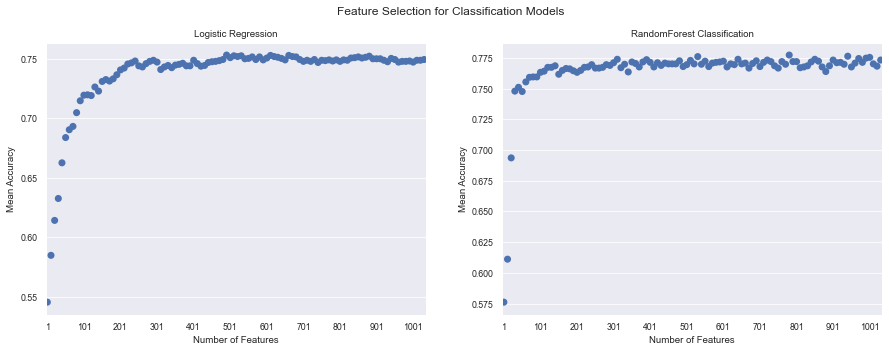

In [14]:
print(f"Optimal number of features for LogisticRegression: {rfe_logreg_CV.n_features_}")
print(f"Optimal number of features for RandomForest {rfe_rf_CV.n_features_}")

# Collecting results in a dataframe
# LogisticRegression
n_scores = len(rfe_logreg_CV.cv_results_["mean_test_score"])

# FOR YOUR CODE
n_features_logreg = range(min_features, 1024+10, 10)
# n_features_logreg = np.flip(np.arange(1024, min_features-10, -10))
mean_logreg_CV_score = rfe_logreg_CV.cv_results_["mean_test_score"]

logreg_feature_selection_results = pd.DataFrame.from_dict({"Number of Features": n_features_logreg, "Mean Accuracy": mean_logreg_CV_score})

# Random Forest Regression
# FOR YOUR CODE
n_features_rf = range(min_features, 1024+10, 10)
# n_features_rf = np.flip(np.arange(1024, min_features, -1))
mean_rf_CV_score = rfe_rf_CV.cv_results_["mean_test_score"]

rf_feature_selection_results = pd.DataFrame.from_dict({"Number of Features": n_features_rf, "Mean Accuracy": mean_rf_CV_score})

# Visualising mean scores over all fold for each feature elimination step

fig, axes = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Feature Selection for Classification Models')
sns.pointplot(ax=axes[0], data=logreg_feature_selection_results, x='Number of Features', y='Mean Accuracy', join=False)
axes[0].set_title(f"Logistic Regression")
tick_spacing = 10
axes[0].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(tick_spacing))

sns.pointplot(ax=axes[1], data=rf_feature_selection_results, x='Number of Features', y='Mean Accuracy', join=False)
axes[1].set_title(f"RandomForest Classification")
axes[1].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(tick_spacing))


Reducing Dataset to Selected Features

In [16]:
# RandomForest selected features, final RFE, using number of features I select (doesn't use CV)
# rfe_rf = RandomForestRegressor()
# rfe_selector = RFE(estimator=rfe_rf, n_features_to_select=270, step=10)
# rfe_selector.fit(X_train_reg, Y_train_reg)

# X_train_reg_rf_reduced = X_train_reg[X_train_reg.columns[rfe_selector.support_]]
# X_test_reg_rf_reduced = X_test_reg[X_test_reg.columns[rfe_selector.support_]]

# LogisticRegression selected features
rfe_logreg = LogisticRegression()
rfe_selector_logreg = RFE(estimator=rfe_logreg, n_features_to_select=150, step=10)
rfe_selector_logreg.fit(X_train_clf, Y_train_clf)

X_train_clf_logreg_reduced = X_train_clf[X_train_clf.columns[rfe_selector_logreg.support_]]
X_test_clf_logreg_reduced = X_train_clf[X_train_clf.columns[rfe_selector_logreg.support_]]


# RandomForest selected features
rfe_rf = RandomForestClassifier()
rfe_selector_rf = RFE(estimator=rfe_rf, n_features_to_select=150, step=10)
rfe_selector_rf.fit(X_train_clf, Y_train_clf)

# RandomForest selected features
X_train_clf_rf_reduced = X_train_clf[X_train_clf.columns[rfe_selector_rf.support_]]
X_test_clf_rf_reduced = X_test_clf[X_test_clf.columns[rfe_selector_rf.support_]]

c:\Users\clarkep\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\clarkep\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

<p>Build and test a model using a reduced set of features:</p>
<ul>
    <li>What was the optimum number of features RFECV selected?</li> 
    <li>Did feature selection alone improve the results of your model?</li>
</ul>

### Model Parameter Selection
We have removed 'not useful' features (descriptors) from our dataset. Now we will find the optimum parameters for predicting the target property or classes from these remaining features


#### Regression using Random Forest as an example

In [18]:
# initializing our ML model
rf_reg = RandomForestRegressor()

# parameters we would like to fine-tune
param_grid_reg = {
    'n_estimators': [200, 500, 800],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4,5,6,7],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
}

# sklearn method for finding best parameters sequentially via CV
rf_reg_param_CV = GridSearchCV(
    estimator=rf_reg,
    param_grid=param_grid_reg,
    cv=10,
    scoring='r2'
)

# applying search for best parametrs using the reduced feature set from before
rf_reg_param_CV.fit(X_train_reg_rf_reduced, Y_train_reg)

print(f"Best Parameters {rf_reg_param_CV.best_params_} with average score of {rf_reg_param_CV.best_score_}")


Best Parameters {'criterion': 'absolute_error', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 800} with average score of 0.47950296377062


<p>Build and test a model using a reduced set of features AND the best model parameters you found through the method above:</p>
<ul>
    <li>What were the best parameters selected by GridSearchCV?</li> 
    <li>Did feature selection AND best model parameter selection improve model performance?</li>
</ul>

#### Classification using Random Forest as an example

In [19]:
# initializing our ML model
rf_clf = RandomForestClassifier()

# parameters we would like to fine-tune
param_grid_clf = {
    'n_estimators': [200, 500, 800],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4,5,6,7],
    'criterion': ['entropy', 'gini']
}

# sklearn method for finding best parameters sequentially via CV
rf_clf_param_CV = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid_clf,
    cv=10,
    scoring='accuracy'
)

# applying search for best parametrs using the reduced feature set from before
rf_clf_param_CV.fit(X_train_clf_rf_reduced, Y_train_clf)

print(f"Best Parameters: {rf_clf_param_CV.best_params_} with average score of {rf_clf_param_CV.best_score_}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200} with average score of 0.742979945482866


<p>Build and test a model using a reduced set of features AND the best model parameters you found through the method above:</p>
<ul>
    <li>What were the best parameters selected by GridSearchCV?</li> 
    <li>Did feature selection AND best model parameter selection improve model performance?</li>
</ul>